In [1]:
from kan.experiments.multkan_hparam_sweep import sweep_multkan, evaluate_params
import numpy as np
import pandas as pd
import torch
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kan.custom_processing import remove_outliers_iqr
import json
import datetime

file_tuning = "JHC_x_HCO3-_20251111_1010"
name_y = "log_x_HCO3-"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"This script is running on {device}.")

dir_current = os.getcwd()
save_heading = os.path.join(dir_current, "extra_figures", file_tuning + "_analysis")

d_opt = pd.read_excel(
    os.path.join(dir_current, "multkan_sweep_autosave", file_tuning + ".xlsx"), sheet_name='best_avg_by_params',
)

This script is running on cpu.


In [2]:
filepath = os.path.join(dir_current, "Alamo_Data_JHC.csv")

filedata = pd.read_csv(filepath)
name_X = ["CO2_loading", "MEA_mol", "Temp"]
df_in = filedata[name_X]
df_out = filedata[[name_y]]

df_in_final, df_out_final = remove_outliers_iqr(df_in, df_out)

removed_count = len(df_in) - len(df_in_final)  # 몇 개 지웠는지 세기
print(f"이상치 제거 후 데이터 수: {len(df_in_final)} 개 ({removed_count} 개 제거됨)")
print("--- 이상치 제거 완료 ---\n")

X = df_in_final[name_X].values
y = df_out_final[name_y].values.reshape(-1, 1)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2,
                                                  random_state=42)  # 0.2 × 0.8 = 0.16 (전체의 16%)

print(f"전체 데이터셋 크기: {len(X)}")
print(f"훈련셋 크기: {len(X_train)} ({len(X_train) / len(X) * 100:.1f}%)")
print(f"검증셋 크기: {len(X_val)} ({len(X_val) / len(X) * 100:.1f}%)")
print(f"테스트셋 크기: {len(X_test)} ({len(X_test) / len(X) * 100:.1f}%)")

# 1. MinMaxScaler 객체 생성 --- 범위를 0.1~0.9로 재설정
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_norm = scaler_X.fit_transform(X_train)  # 훈련 데이터로 스케일러 학습 및 변환 (fit_transform)
y_train_norm = scaler_y.fit_transform(y_train)  # X_train의 각 변수(컬럼)별로 최소값은 0, 최대값은 1이 되도록 변환됩니다.

X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)

y = df_out_final[name_y].values.reshape(-1, 1)

이상치 제거 후 데이터 수: 11410 개 (0 개 제거됨)
--- 이상치 제거 완료 ---

전체 데이터셋 크기: 11410
훈련셋 크기: 7302 (64.0%)
검증셋 크기: 1826 (16.0%)
테스트셋 크기: 2282 (20.0%)


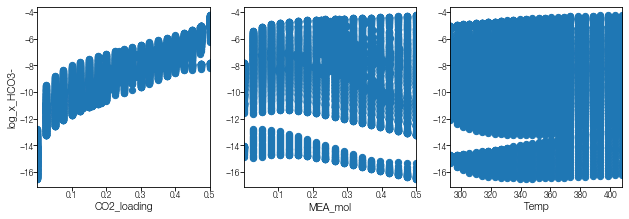

In [10]:
import matplotlib.pyplot as plt

num_input = X.shape[1]
fig, axs = plt.subplots(1, num_input, figsize=(10, 3))
for i in range(num_input):
    ax = axs[i]
    ax.scatter(X[:, i], y)
    ax.set_xlabel(name_X[i])
axs[0].set_ylabel(name_y)
plt.show()


| train_loss: 2.04e-02 | test_loss: 2.01e-02 | reg: 2.38e+00 | : 100%|█| 50/50 [00:26<00:00,  1.87it
| train_loss: 1.76e-02 | test_loss: 1.80e-02 | reg: 2.53e+00 | : 100%|█| 50/50 [00:27<00:00,  1.80it
| train_loss: 3.12e-02 | test_loss: 3.14e-02 | reg: 2.67e+00 | : 100%|█| 50/50 [00:25<00:00,  1.96it
| train_loss: 3.94e-02 | test_loss: 3.95e-02 | reg: 2.45e+00 | : 100%|█| 50/50 [00:25<00:00,  1.95it


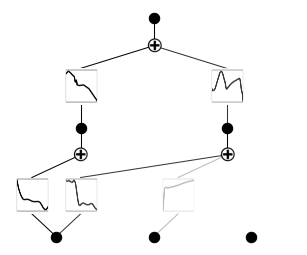

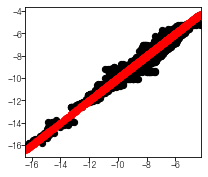

In [11]:
d_opt_flat = d_opt.iloc[0]
d_opt_flat = d_opt_flat.to_dict()
params = {k: v for k, v in d_opt_flat.items() if "param_" in k}
params = {key.replace('param_', ''): value for key, value in params.items()}

res, model, fit_kwargs, dataset = evaluate_params(
    X_train_norm, y_train_norm, X_val_norm, y_val_norm, params, X_test_norm, y_test_norm,
    0, scaler_y, device.type,
    save_heading=save_heading
)

In [12]:
from kan.utils import ex_round
model.auto_symbolic(weight_simple=0.)
model.fit(dataset=dataset, **fit_kwargs)
ex_round(model.symbolic_formula()[0][0], 4)

r2 is 0.9488140940666199
fixing (0,0,0) with tan, r2=0.95, c=3
Best value at boundary.
r2 is 0.9605470299720764
fixing (0,0,1) with tanh, r2=0.96, c=3
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,1,0) with 0
r2 is 0.9584854245185852
fixing (0,1,1) with tan, r2=0.96, c=3
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,2,0) with 0
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,2,1) with 0
Best value at boundary.
r2 is 0.9279110431671143
fixing (1,0,0) with abs, r2=0.93, c=3
r2 is 0.48889997601509094
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (1,1,0) with tan, r2=0.49, c=3


| train_loss: 5.72e-02 | test_loss: 5.90e-02 | reg: 2.94e-01 | : 100%|█| 50/50 [00:15<00:00,  3.13it


-0.0153*tan(0.0304*tan(2.7924*x_2 - 7.7734) - 0.0124*tanh(9.9988*x_1 - 3.6034) + 4.5274) - 0.0969*Abs(1.3342*tan(2.4147*x_1 - 1.3097) - 2.6542) + 1.0105

{'train': 0.9052560392794297, 'test': 0.9028797488759039}


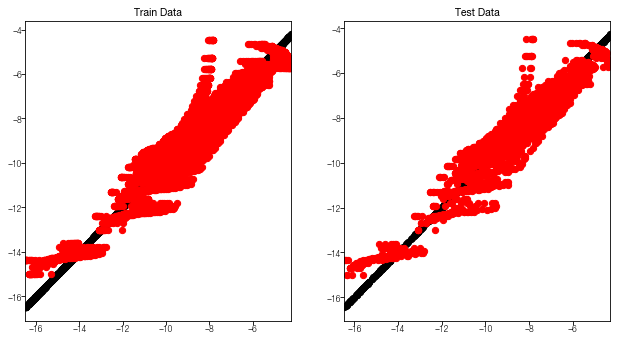

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

y_pred_norm_test = model.forward(x=dataset['test_input']).detach().cpu().numpy()
y_pred_norm_train = model.forward(x=dataset['train_input']).detach().cpu().numpy()

y_pred_test = scaler_y.inverse_transform(y_pred_norm_test)
y_pred_train = scaler_y.inverse_transform(y_pred_norm_train)

r2_score = {
    "train": r2_score(y_train, y_pred_train),
    "test": r2_score(y_test, y_pred_test),
}
print(r2_score)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax_train = ax[0]
ax_train.scatter(y_train, y_train, color='k')
ax_train.scatter(y_train, y_pred_train, color='r')
ax_train.set_title("Train Data")

ax_test = ax[1]
ax_test.scatter(y_test, y_test, color='k')
ax_test.scatter(y_test, y_pred_test, color='r')
ax_test.set_title("Test Data")

plt.savefig(save_heading + "_symbolic_eval.png")
plt.show()

In [14]:
torch.save(model.state_dict(), f"{save_heading}_model.pt")

In [15]:
import pickle

with open(save_heading + 'my_scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)

with open(save_heading + 'my_scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)